### Solution to the 2D boundary layer equations

Siavash Toosi and Philipp Schlatter, LSTM/FAU, 2024

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib widget

Boundary-layer equations for a flow in steady state and vanishing pressure gradient in $x$ (zero pressure gradient, ZPG), in non-dimensional form introducing the Reynolds number $Re=U_\infty L/\nu$::
$$\frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} = 0$$
$$u\frac{\partial u}{\partial x} + v\frac{\partial u}{\partial y} = \frac{1}{Re} \frac{\partial^2 u}{\partial y^2}$$ 
$$\frac{\partial p}{\partial y} = 0$$

First, we realise that the pressure $p=const$. The momentum equations are integrated in $x$ due to the parabolic nature. We thus evaluate the vertical derivatives $\partial u/\partial y$ and $\partial^2 u/\partial y^2$ using central differences at the old $x_{i}$, followed by first-order Euler in $x$ to compute $u$ at $x_{i}$. The continuity equation then gives us consistent values for $v$ by first-order integration.

In [2]:
Nx = 1000
Ny = 80
Re = 5000.0

In [3]:
# coordinates
ymax = 3 * 4.91/np.sqrt(Re)

x = np.linspace( 0.0 , 1.0 , Nx )
y = np.linspace( 0.0 , ymax , Ny )

dx = x[1]-x[0]
dy = y[1]-y[0]

# initialise arrays
U = np.ones((Nx,Ny))
V = np.zeros((Nx,Ny))

# boundary condition
U[:,0] = 0.0
V[:,0] = 0.0

# marching algorithm
for ix in range(1,Nx):
    dudy    = (1/(2*dy)) * (U[ix-1,2:]-U[ix-1,0:Ny-2])
    d2udy2  = (1/dy**2) * (U[ix-1,2:]-2*U[ix-1,1:Ny-1]+U[ix-1,0:Ny-2])
    U[ix,1:Ny-1] = U[ix-1,1:Ny-1] \
                 - dx * V[ix-1,1:Ny-1]  / U[ix-1,1:Ny-1] * dudy \
                 + dx/Re * d2udy2       / U[ix-1,1:Ny-1]
    U[ix,0] = 0.0 # not necessary, just in case
    
    dudx       = (1/dx) * (U[ix,:]-U[ix-1,:]) # upwind in x
    # dudx[1:Ny] = .5*(dudx[1:Ny]+dudx[0:Ny-1]) # take the average
    # DUDX[ix,:] = dudx # for debug
    
    V[ix,1:Ny] = np.cumsum(-dy*dudx[0:Ny-1])
    V[ix,0] = 0.0 # not necessary, just in case

# compute boundary layer thickness
d99     = np.zeros((Nx,1))
dstar   = np.zeros((Nx,1))
theta   = np.zeros((Nx,1))
for i in range(0,len(x)):
    d99[i]   = np.interp(0.99,U[i,:],y)
    dstar[i] = np.trapz( 1-U[i,:], y )
    theta[i] = np.trapz( U[i,:]*(1-U[i,:]), y )   
theta[0]=theta[1]

# save the data for later    
UU = U
yy=y

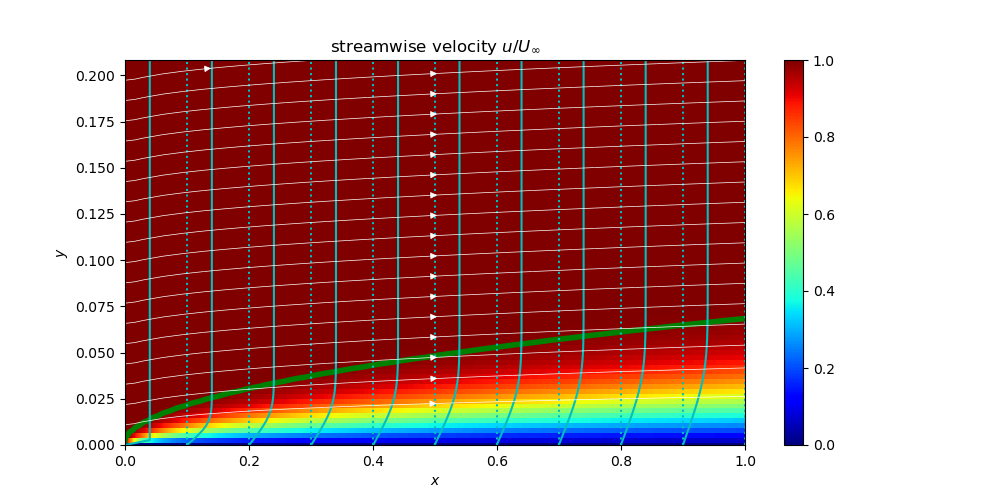

In [4]:
XX, YY = np.meshgrid(x,y)

plt.figure(figsize=(10,5))
plt.pcolormesh(x,y,U.T,shading='nearest',cmap='jet')
plt.colorbar()
plt.plot(x,d99,'g',linewidth=4)
plt.title('streamwise velocity $u/U_\infty$')

for i in range(0,11):
    this_i = np.argmin(np.abs(x-np.single(i)*0.1))
    plt.plot(x[this_i]+U[this_i,:]*.04,y,'c')
    plt.plot(x[this_i]*np.ones((Ny,1)),y,':c')

seed_points = np.zeros((20,2))
# seed_points[:,1] = ymax * np.linspace(.05,1.0,20)**2
seed_points[:,1] = ymax * np.linspace(0,1.0,20)
# seed_points = np.array([[np.zeros((10,1))], np.reshape( np.linspace(ymax/20.0,ymax,10) , 1,-1) ]])
plt.streamplot( XX,YY , U.T,V.T , start_points=seed_points , \
               color='white',maxlength=3,linewidth=0.5,broken_streamlines=True)

plt.xlabel('$x$')
plt.ylabel('$y$')
plt.xlim(0,1)
plt.ylim(0,np.max(y))

plt.show()

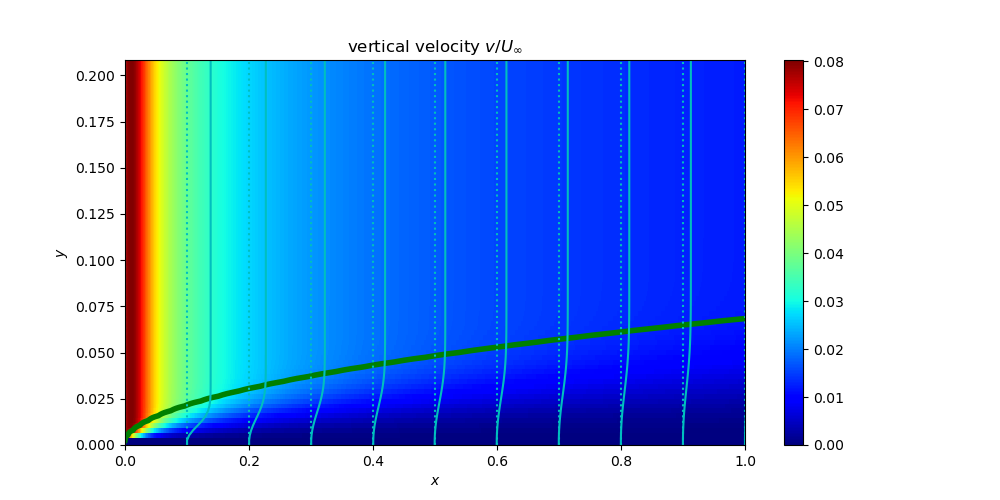

In [5]:
plt.figure(figsize=(10,5))
plt.pcolormesh(x,y,V.T,shading='nearest',cmap='jet')
plt.colorbar()
plt.plot(x,d99,'g',linewidth=4)
plt.title('vertical velocity $v/U_\infty$')

for i in range(0,11):
    this_i = np.argmin(np.abs(x-np.single(i)*0.1))
    plt.plot(x[this_i]+V[this_i,:],y,'c')
    plt.plot(x[this_i]*np.ones((Ny,1)),y,':c')
    
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.xlim(0,1)
plt.ylim(0,np.max(y))
plt.show()

### Comparison to Blasius solution

We can now compare the solution of the boundary-layer equations towards the end of our integration domain. We start with the shape factor $H_{12}=\delta^*/\theta$ as a function of $x$. We observe a fair comparison of this arguable quite sensitive quantity.

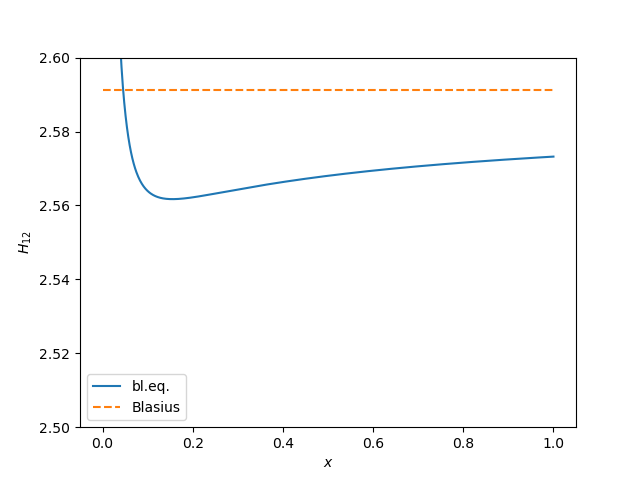

In [6]:
plt.figure()
plt.plot(x,dstar/theta,label='bl.eq.')
plt.ylim(2.5,2.6)
plt.plot(x,x*0+2.591100362,'--',label='Blasius')
plt.xlabel(r'$x$')
plt.ylabel(r'$H_{12}$')
plt.legend()           
plt.show()

In [7]:
def ff(u):
    f0 =   u[1]
    f1 =   u[2]
    f2 = - 0.5*u[0] * u[2]
    return np.array([f0,f1,f2])
def RK4(a,h,L):
    imax = int(L/h)
    X = np.arange(imax+1)*h
    U = np.zeros((imax+1,3)); U[0,:] = [0,0,a]
    for i in range(imax):
        K1 = ff(U[i,:]       )
        K2 = ff(U[i,:]+K1*h/2)
        K3 = ff(U[i,:]+K2*h/2)
        K4 = ff(U[i,:]+K3*h  )
        U[i+1,:] = U[i,:] + h*(K1+2*K2+2*K3+K4)/6
    return X,U
def shoot(a,h,L):
    X,U = RK4(a,h,L)
    return (1.0-U[-1,1])
def blasius(h,L,tol,nmax):
    a = 0; fa = shoot(a,h,L)
    b = 1; fb = shoot(b,h,L)
    if (fa*fb > 0):
        raise RuntimeError('Bad initial interval.')
    n = 0; delta = (b-a)/2
    while (abs(delta) >= tol and n <= nmax):
        delta = (b-a)/2; n = n + 1;
        x = a + delta; fx = shoot(x,h,L)
        print(" x = %14.7e (Estimated error %13.7e at iteration %d)" % (x,abs(delta),n))
        if (fx*fa > 0):
            a = x;  fa = fx
        else :
            b = x;  fb = fx
    if (n > nmax):
        raise RuntimeError('Too many iterations.')
    return x

In [8]:
# parameters
nmax = 100
h   = 0.01
L   = 30
tol = 1e-8
# compute the value of f''(0)
a = blasius(h,L,tol,nmax)
# recompute the Blasius solution with the optimised value for f''(0)
eta,f = RK4(a,h,L)

print("Final value for f''(0) = %.10f " % f[0,2])
d99bl = np.interp(0.99,f[:,1],eta)

 x =  5.0000000e-01 (Estimated error 5.0000000e-01 at iteration 1)
 x =  2.5000000e-01 (Estimated error 2.5000000e-01 at iteration 2)
 x =  3.7500000e-01 (Estimated error 1.2500000e-01 at iteration 3)
 x =  3.1250000e-01 (Estimated error 6.2500000e-02 at iteration 4)
 x =  3.4375000e-01 (Estimated error 3.1250000e-02 at iteration 5)
 x =  3.2812500e-01 (Estimated error 1.5625000e-02 at iteration 6)
 x =  3.3593750e-01 (Estimated error 7.8125000e-03 at iteration 7)
 x =  3.3203125e-01 (Estimated error 3.9062500e-03 at iteration 8)
 x =  3.3398438e-01 (Estimated error 1.9531250e-03 at iteration 9)
 x =  3.3300781e-01 (Estimated error 9.7656250e-04 at iteration 10)
 x =  3.3251953e-01 (Estimated error 4.8828125e-04 at iteration 11)
 x =  3.3227539e-01 (Estimated error 2.4414062e-04 at iteration 12)
 x =  3.3215332e-01 (Estimated error 1.2207031e-04 at iteration 13)
 x =  3.3209229e-01 (Estimated error 6.1035156e-05 at iteration 14)
 x =  3.3206177e-01 (Estimated error 3.0517578e-05 at ite

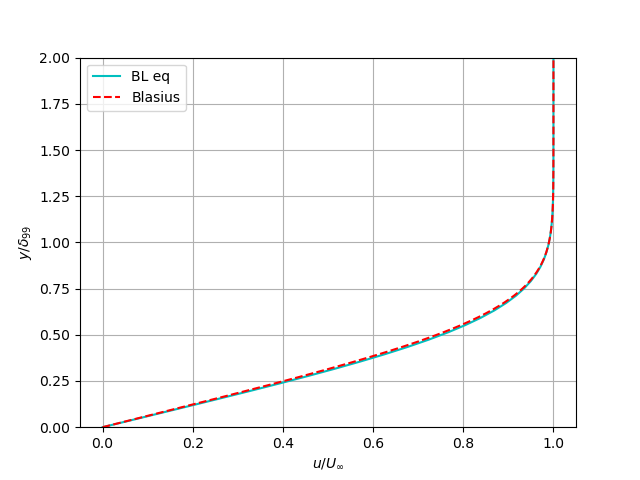

In [9]:
plt.figure()
this_i = 950
Ueq = UU[this_i,:]
d99eq = np.interp(0.99,Ueq,yy)
plt.plot(U[this_i,:],yy/d99eq,'c',label='BL eq')
plt.plot(f[:,1],eta/d99bl,'r--',label="Blasius")
plt.ylim(0,2)
plt.xlabel(r'$u/U_\infty$')
plt.ylabel(r'$y/\delta_{99}$')
plt.legend()
plt.grid()
plt.show()